In [24]:
from PIL import Image
#from cityscapesscripts.helpers import labels
from cityscapesscripts.helpers import labels as cs_labels
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import gc
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.datasets import Cityscapes

In [25]:
# Set seeds for reproducibility
def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.mps.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
SEED = 42
set_seeds(SEED)
print(f"Seeds set for reproducibility is {SEED}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if torch.mps.is_available() 
                      else "cpu"
                    )
print(DEVICE)

from contextlib import contextmanager
import ssl
# Disable SSL verification for urllib requests on MacOS
# This is a workaround for the "SSL: CERTIFICATE_VERIFY_FAILED" error on MacOS
@contextmanager
def no_ssl_verification():
    """Temporarily disable SSL verification"""
    old_context = ssl._create_default_https_context
    ssl._create_default_https_context = ssl._create_unverified_context
    try:
        yield
    finally:
        ssl._create_default_https_context = old_context

Seeds set for reproducibility is 42
cuda


In [26]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, targets_dir, image_transform=None, target_transform=None):
        """
        Args:
            images_dir (string): Directory with all the images.
            targets_dir (string): Directory with all the target masks.
            image_transform (callable, optional): Optional transform to be applied on images.
            target_transform (callable, optional): Optional transform to be applied on targets.
        """
        self.images_dir = images_dir
        self.targets_dir = targets_dir
        self.image_transform = image_transform
        self.target_transform = target_transform
        
        # Get all image filenames
        self.image_filenames = [f for f in os.listdir(images_dir) 
                               if f.lower().endswith(('.png'))]
        self.image_filenames.sort()
        
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Load target mask
        target_name = img_name.replace('.png', '_trainId.png')
        target_path = os.path.join(self.targets_dir, target_name)
        target = Image.open(target_path)
        
        # Apply transforms
        if self.image_transform:
            image = self.image_transform(image)
        
        if self.target_transform:
            target = self.target_transform(target)
       # else:
       #     # Default: convert to tensor
       #     target = torch.from_numpy(target)
        
        return image, target

Actual Colors:


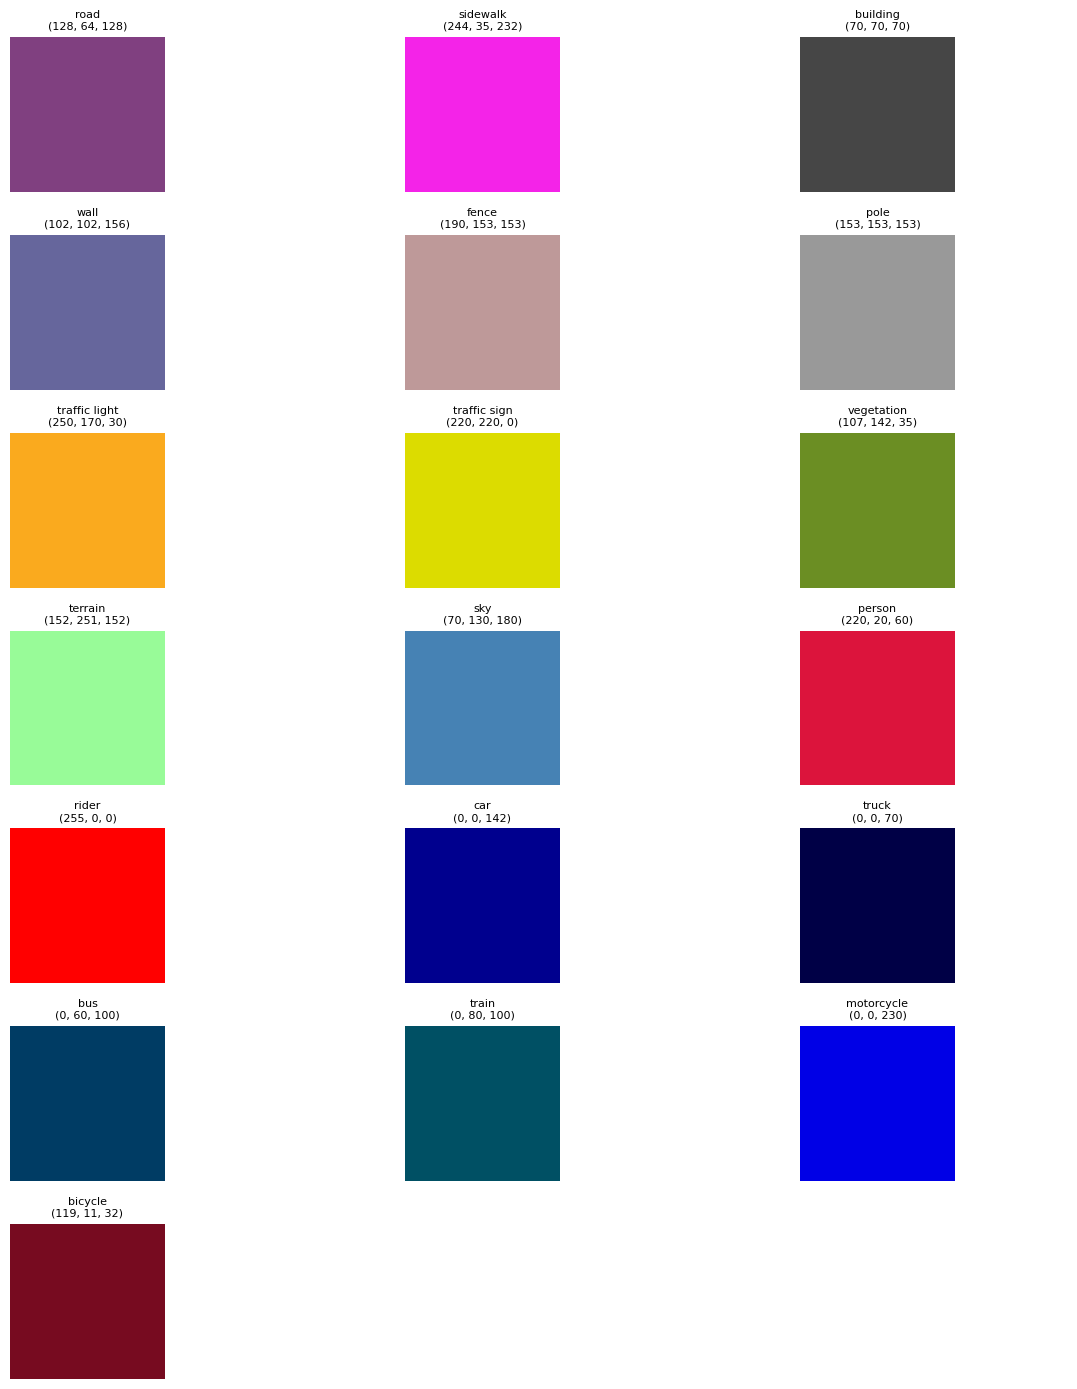

In [27]:
print("Actual Colors:")

# Calculate grid dimensions (3 colors per row)
cols = 3

labels = [label for label in cs_labels.labels if label.trainId != 255 and label.trainId != -1]
rows = (len(labels) + cols - 1) // cols  # Ceiling division

# Create a figure and axes to display the colors in a grid
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 2))

# Flatten axes array for easier indexing
if rows == 1:
    axes = [axes] if cols == 1 else axes
else:
    axes = axes.flatten()

for i, label in enumerate(labels): 
    color = np.array(label.color) / 255.0  # Normalize RGB values to [0, 1]
    axes[i].imshow([[color]])  # Display the color as a small image
    # Add color name and RGB values to the title
    axes[i].set_title(f"{label.name}\n{label.color}", fontsize=8)
    axes[i].axis('off')  # Hide the axes

# Hide any unused subplots
for i in range(len(labels), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [28]:
path_images = "syn_resized_images"
path_target = "syn_resized_gt"

image_transform = transforms.Compose([
    transforms.Resize((256, 466)), # We maintain the og aspect ratio
    transforms.ToTensor(),  # Converts PIL Image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize with ImageNet parameters
])

target_transform = transforms.Compose([
    transforms.Resize((256, 466), interpolation=Image.NEAREST), # This interpolation ensure that all pixels have a correct value of their class
    transforms.Lambda(lambda x: torch.from_numpy(np.array(x)).long())
])
syn_dataset = SegmentationDataset(images_dir=path_images, targets_dir=path_target, image_transform=image_transform, target_transform=target_transform)
# Get total dataset size
total_size = len(syn_dataset)
print(f"Total dataset size: {total_size}")

# Calculate split sizes (60% train, 10% val, 30% test)
train_size = int(0.6 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

print(f"Train size: {train_size} ({train_size/total_size*100:.1f}%)")
print(f"Validation size: {val_size} ({val_size/total_size*100:.1f}%)")
print(f"Test size: {test_size} ({test_size/total_size*100:.1f}%)")

# Create random splits
syn_train_dataset, syn_val_dataset, syn_test_dataset = random_split(
    syn_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)  # For reproducibility
)

# Create DataLoaders
batch_size = 4 #8

syn_train_dataloader = DataLoader(
    syn_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED) 
)


syn_val_dataloader = DataLoader(
    syn_val_dataset,
    batch_size=batch_size,
    shuffle=True,  
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

syn_test_dataloader = DataLoader(
    syn_test_dataset,
    batch_size=batch_size,
    shuffle=True,  
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

print(f"\nDataLoaders created:")
print(f"Train batches: {len(syn_train_dataloader)}")
print(f"Validation batches: {len(syn_val_dataloader)}")
print(f"Test batches: {len(syn_test_dataloader)}")

Total dataset size: 5000
Train size: 3000 (60.0%)
Validation size: 500 (10.0%)
Test size: 1500 (30.0%)

DataLoaders created:
Train batches: 750
Validation batches: 125
Test batches: 375


In [ ]:
def cityscapes_mask_to_train_ids(mask):
    mask_np = np.array(mask)
    labels_mapping = {label.id: label.trainId for label in cs_labels.labels if label.trainId != -1}
    labels_mapping[-1] = 255  # Map invalid labels to 255
    mask_np = np.vectorize(labels_mapping.get)(mask_np)
    mask_np = np.where(mask_np <= 18, mask_np, 255).astype(np.uint8)  # Ensure that all pixels are within the range of train IDs
    return torch.from_numpy(mask_np).long()

real_target_transform = transforms.Compose([
    transforms.Resize((256, 466), interpolation=Image.NEAREST), # This interpolation ensure that all pixels have a correct value of their class
    transforms.Lambda(lambda x: cityscapes_mask_to_train_ids(x))  # Convert Cityscapes mask to train IDs
])

real_train_dataset = Cityscapes(
    root='cityscapes',
    split='train',
    mode='fine',
    target_type='semantic',
    transform=image_transform,
    target_transform=real_target_transform
)

real_val_dataset = Cityscapes(
    root='cityscapes',
    split='val',
    mode='fine',
    target_type='semantic',
    transform=image_transform,
    target_transform=real_target_transform
)

real_test_dataset = Cityscapes(
    root='cityscapes',
    split='test',
    mode='fine',
    target_type='semantic',
    transform=image_transform,
    target_transform=real_target_transform
)

# Print dataloaders sizes
real_total_size = len(real_train_dataset) + len(real_val_dataset) + len(real_test_dataset)
print(f"Total dataset size: {real_total_size}")
print(f"Train size: {len(real_train_dataset)} ({len(real_train_dataset)/real_total_size*100:.1f}%)")
print(f"Validation size: {len(real_val_dataset)} ({len(real_val_dataset)/real_total_size*100:.1f}%)")
print(f"Test size: {len(real_test_dataset)} ({len(real_test_dataset)/real_total_size*100:.1f}%)")


real_train_dataloader = DataLoader(
    real_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

real_val_dataloader = DataLoader(
    real_val_dataset,
    batch_size=batch_size,
    shuffle=True,  
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

real_test_dataloader = DataLoader(
    real_test_dataset,
    batch_size=batch_size,
    shuffle=True,  
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

Total dataset size: 5000
Train size: 2975 (59.5%)
Validation size: 500 (10.0%)
Test size: 1525 (30.5%)


# DeeplabV3

In [30]:
def visualize_segmentation(name, epoch, sim_dataloader, real_dataloader, num_samples=4, start_idx=0, deterministic=False):
    """
    Visualize segmentation results from a trained model using both simulation and real dataloaders
    
    Args:
        name: The model name used for saving (e.g., "DA_deeplabv3_imagenet1k")
        epoch: The epoch number to load (or "best_supervised"/"best_unsupervised" for best models)
        sim_dataloader: DataLoader for simulation data
        real_dataloader: DataLoader for real data
        num_samples: Number of samples to visualize from each domain (default: 4)
        start_idx: Starting index for deterministic sampling (used when deterministic=True)
        deterministic: If True, select images deterministically by index
    """
    # Load the model based on name and epoch
    if epoch == "best_supervised":
        model_path = f"models/{name}_best_supervised_model.pth"
    elif epoch == "best_unsupervised":
        model_path = f"models/{name}_best_unsupervised_model.pth"
    else:
        model_path = f"models/{name}_epoch_{epoch}.pth"
    
    # Check if model file exists
    if not os.path.exists(model_path):
        print(f"Model file not found: {model_path}")
        return
    
    print(f"Loading model from: {model_path}")
    
    # Create the model architecture
    from torchvision.models.segmentation import deeplabv3_resnet50
    import torch.nn as nn
    
    if DEVICE.type == 'mps':
        print("mps detected, using no_ssl_verification")
        with no_ssl_verification():
            model = deeplabv3_resnet50(weights='COCO_WITH_VOC_LABELS_V1')
    else:
        model = deeplabv3_resnet50(weights='COCO_WITH_VOC_LABELS_V1')
    
    # Modify classifier for the correct number of classes
    model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
    model = model.to(DEVICE)
    
    # Load the checkpoint
    checkpoint = torch.load(model_path, map_location=DEVICE)
    
    # Load model state (filter out aux_classifier keys if present)
    state_dict = checkpoint["model_state_dict"]
    filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith("aux_classifier.")}
    model.load_state_dict(filtered_state_dict, strict=False)
    
    epoch = checkpoint.get("epoch", "unknown")
    print(f"Model loaded successfully from epoch {epoch}")
    
    # Set model to evaluation mode
    model.eval()
    
    # Function to get images deterministically or non-deterministically
    def get_images_from_dataloader(dataloader, num_samples, start_idx, deterministic):
        if deterministic:
            # For true determinism, access the dataset directly instead of the dataloader
            # This avoids the randomness caused by shuffle=True
            dataset = dataloader.dataset
            
            # Handle the case where the dataset is a Subset (from random_split)
            if hasattr(dataset, 'dataset') and hasattr(dataset, 'indices'):
                # This is a Subset from random_split
                orig_dataset = dataset.dataset
                indices = dataset.indices
                
                # Select specific indices
                selected_indices = indices[start_idx:start_idx + num_samples]
                
                # Get samples directly from the original dataset
                images = []
                targets = []
                for idx in selected_indices:
                    img, tgt = orig_dataset[idx]
                    images.append(img.unsqueeze(0))  # Add batch dimension
                    targets.append(tgt.unsqueeze(0))
                
                # Stack to form batches
                images = torch.cat(images, dim=0)
                targets = torch.cat(targets, dim=0)
            else:
                # Regular dataset
                images = []
                targets = []
                for i in range(start_idx, min(start_idx + num_samples, len(dataset))):
                    img, tgt = dataset[i]
                    images.append(img.unsqueeze(0))
                    targets.append(tgt.unsqueeze(0))
                
                # Stack to form batches
                images = torch.cat(images, dim=0)
                targets = torch.cat(targets, dim=0)
        else:
            # Non-deterministic: Just get the next batch
            images, targets = next(iter(dataloader))
            
            # Limit to the required number of samples
            images = images[:num_samples]
            targets = targets[:num_samples]
        
        return images, targets
    
    # Get images from both dataloaders
    sim_images, sim_targets = get_images_from_dataloader(sim_dataloader, num_samples, start_idx, deterministic)
    real_images, real_targets = get_images_from_dataloader(real_dataloader, num_samples, start_idx, deterministic)
    
    # Move to device
    sim_images = sim_images.to(DEVICE)
    sim_targets = sim_targets.to(DEVICE)
    real_images = real_images.to(DEVICE)
    real_targets = real_targets.to(DEVICE)
    
    with torch.no_grad():
        # Get predictions for simulation data
        sim_outputs = model(sim_images)['out']
        sim_predictions = torch.argmax(sim_outputs, dim=1)
        
        # Get predictions for real data
        real_outputs = model(real_images)['out']
        real_predictions = torch.argmax(real_outputs, dim=1)
    
    # Move to CPU for visualization
    sim_images = sim_images.cpu()
    sim_targets = sim_targets.cpu()
    sim_predictions = sim_predictions.cpu()
    
    real_images = real_images.cpu()
    real_targets = real_targets.cpu()
    real_predictions = real_predictions.cpu()
    
    def apply_color_map(seg_map):
        """Apply color mapping to segmentation map"""
        colored_map = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
        
        # Get valid labels (excluding ignore classes)
        valid_labels = [label for label in cs_labels.labels if label.trainId != 255 and label.trainId != -1]
        
        for label in valid_labels:
            mask = seg_map == label.trainId
            colored_map[mask] = label.color
            
        return colored_map
    
    # Calculate number of samples to show from each domain
    sim_samples = min(num_samples, len(sim_images))
    real_samples = min(num_samples, len(real_images))
    total_samples = sim_samples + real_samples
    
    # Plot results - 3 columns (original, ground truth, prediction) and rows for each sample
    fig, axes = plt.subplots(total_samples, 3, figsize=(15, total_samples * 4))
    if total_samples == 1:
        axes = axes.reshape(1, -1)
    
    current_row = 0
    
    # Plot simulation samples
    for i in range(sim_samples):
        # Original image
        img = sim_images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
        axes[current_row, 0].imshow(img)
        title_suffix = f" (idx: {start_idx + i})" if deterministic else f" {i+1}"
        axes[current_row, 0].set_title(f'Simulation Image{title_suffix}')
        axes[current_row, 0].axis('off')
        
        # Ground truth
        gt_colored = apply_color_map(sim_targets[i].numpy())
        axes[current_row, 1].imshow(gt_colored)
        axes[current_row, 1].set_title('Ground Truth')
        axes[current_row, 1].axis('off')
        
        # Prediction
        pred_colored = apply_color_map(sim_predictions[i].numpy())
        axes[current_row, 2].imshow(pred_colored)
        axes[current_row, 2].set_title('Prediction')
        axes[current_row, 2].axis('off')
        
        current_row += 1
    
    # Plot real samples
    for i in range(real_samples):
        # Original image
        img = real_images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
        axes[current_row, 0].imshow(img)
        title_suffix = f" (idx: {start_idx + i})" if deterministic else f" {i+1}"
        axes[current_row, 0].set_title(f'Real Image{title_suffix}')
        axes[current_row, 0].axis('off')
        
        # Ground truth
        gt_colored = apply_color_map(real_targets[i].numpy())
        axes[current_row, 1].imshow(gt_colored)
        axes[current_row, 1].set_title('Ground Truth')
        axes[current_row, 1].axis('off')
        
        # Prediction
        pred_colored = apply_color_map(real_predictions[i].numpy())
        axes[current_row, 2].imshow(pred_colored)
        axes[current_row, 2].set_title('Prediction')
        axes[current_row, 2].axis('off')
        
        current_row += 1
    
    sampling_mode = "Deterministic" if deterministic else "Random"
    plt.suptitle(f'Segmentation Results - Model: {name}, Epoch: {epoch} ({sampling_mode} Sampling)', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Clean up
    del model, checkpoint, state_dict, filtered_state_dict


Loading model from: models/DA_deeplabv3_resnet50_best_model_best_supervised_model.pth
Model loaded successfully from epoch 1


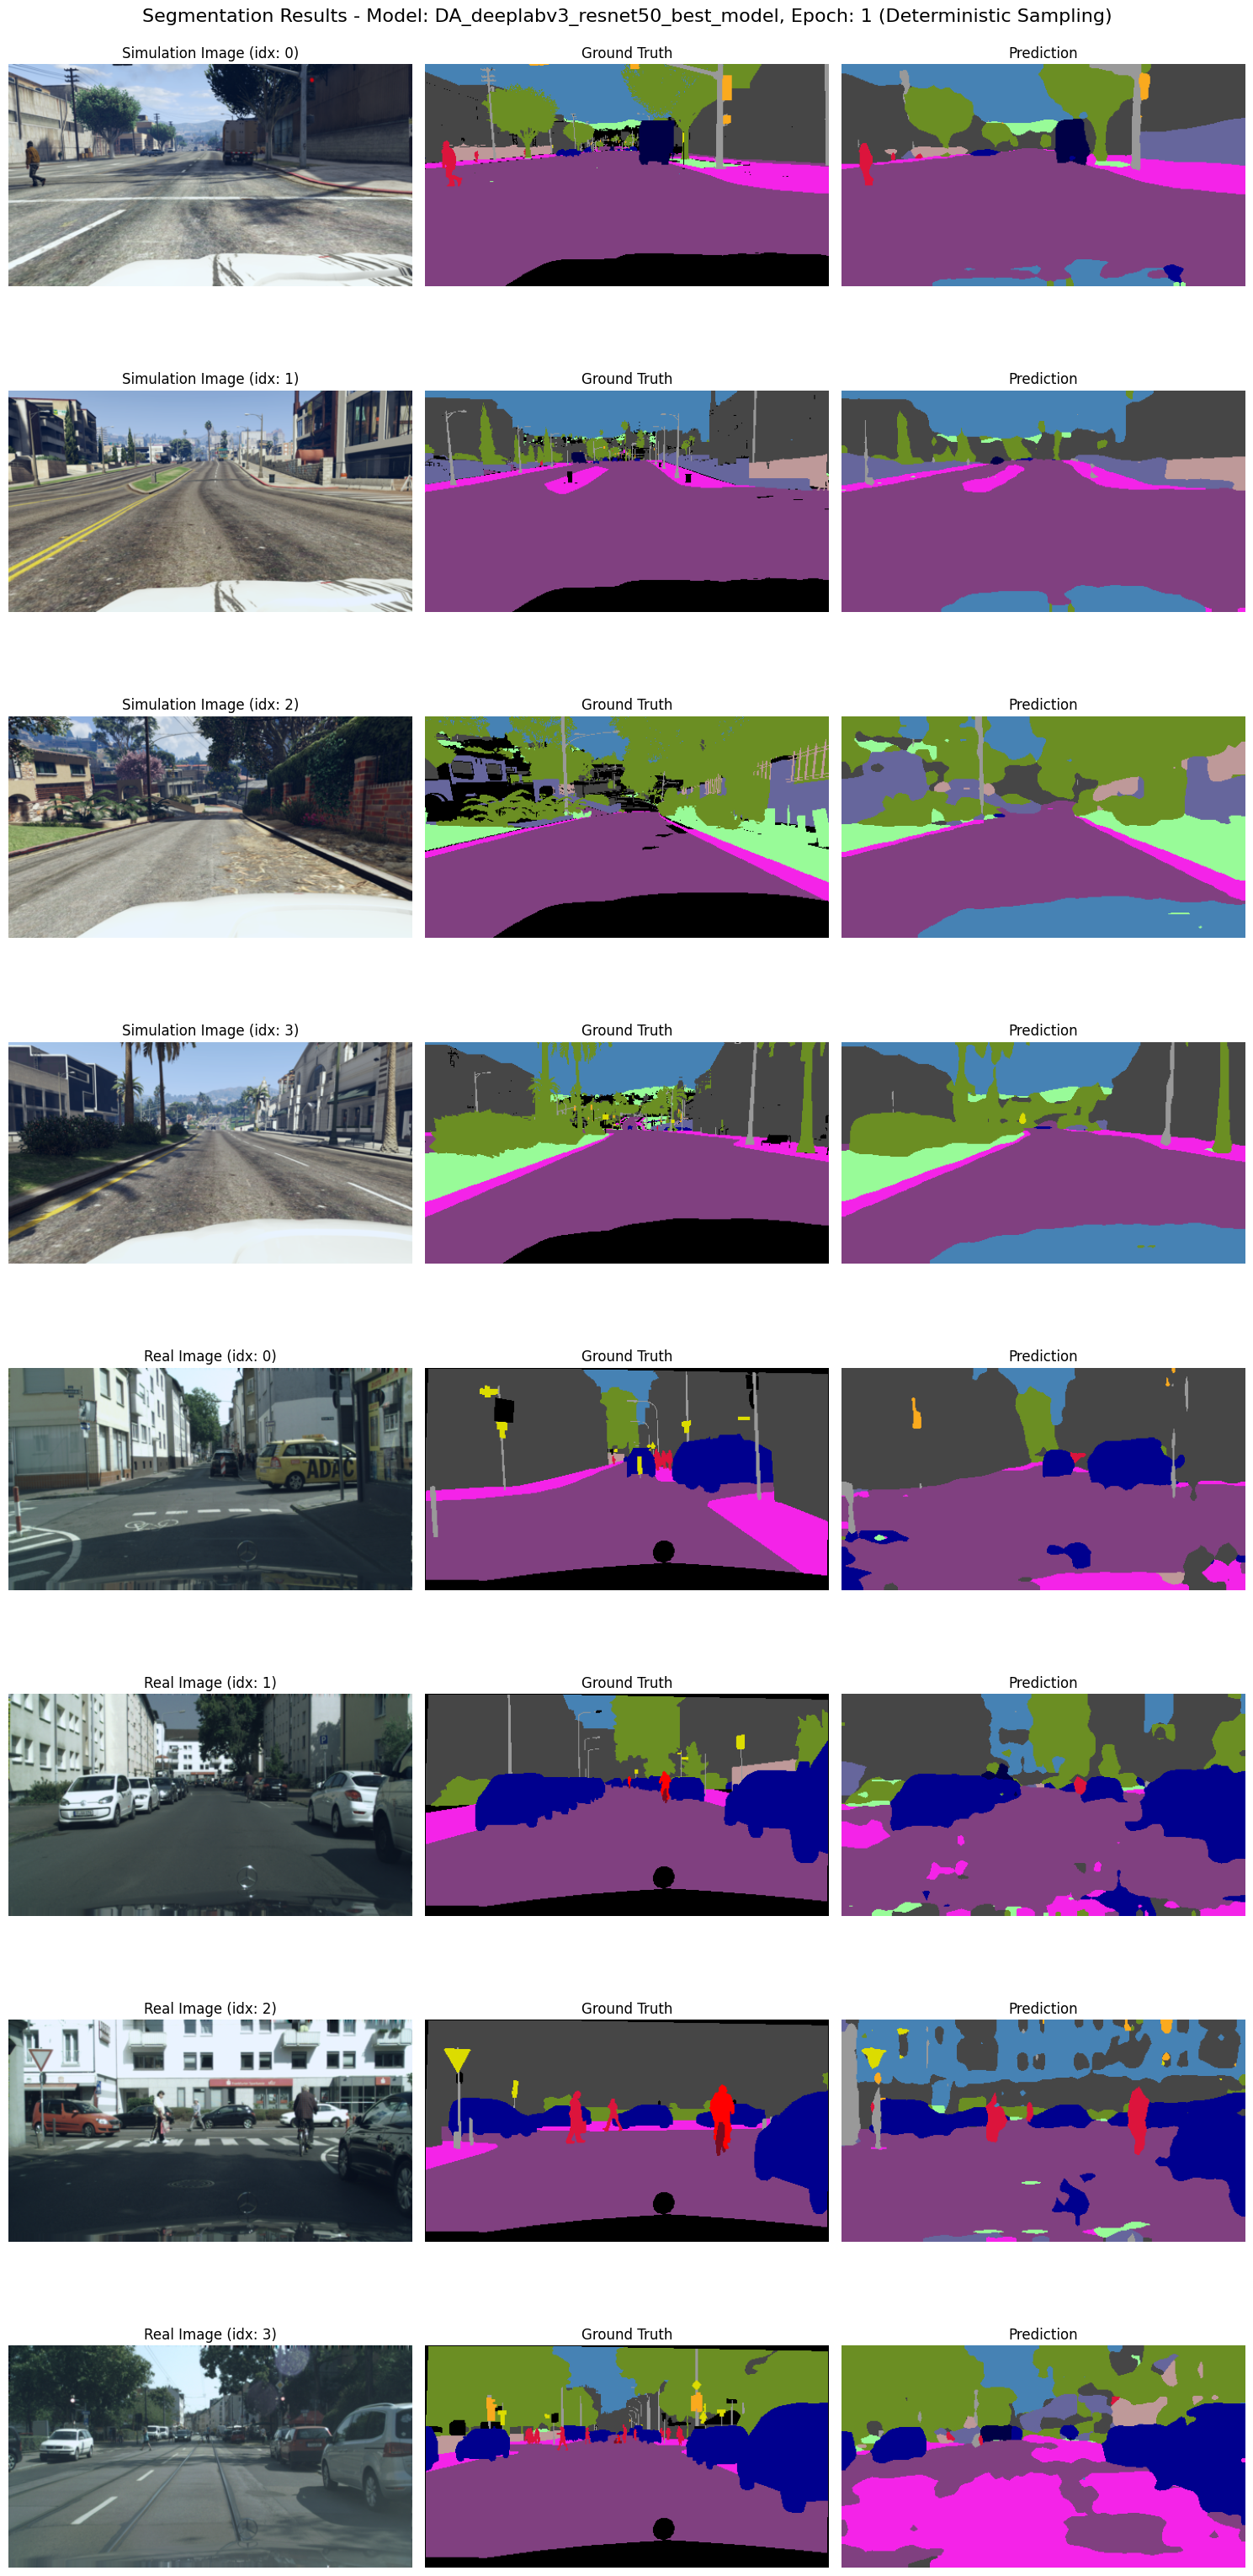

Model file not found: models/DA_deeplabv3_resnet50_best_model_best_unsupervised_model.pth


In [33]:
NUM_CLASSES = 19  


name = "DA_deeplabv3_imagenet1k"
name = "DA_deeplabv3_resnet50_best_model"

visualize_segmentation(
    name=name, 
    epoch="best_supervised", 
    sim_dataloader=syn_val_dataloader, 
    real_dataloader=real_val_dataloader, 
    num_samples=4,
    deterministic=True,
)
visualize_segmentation(
    name=name, 
    epoch="best_unsupervised", 
    sim_dataloader=syn_val_dataloader, 
    real_dataloader=real_val_dataloader, 
    num_samples=4,
    deterministic=True,
)


Loading model from: models/DA_deeplabv3_resnet50_best_model_best_supervised_model.pth
Model loaded successfully from epoch 1


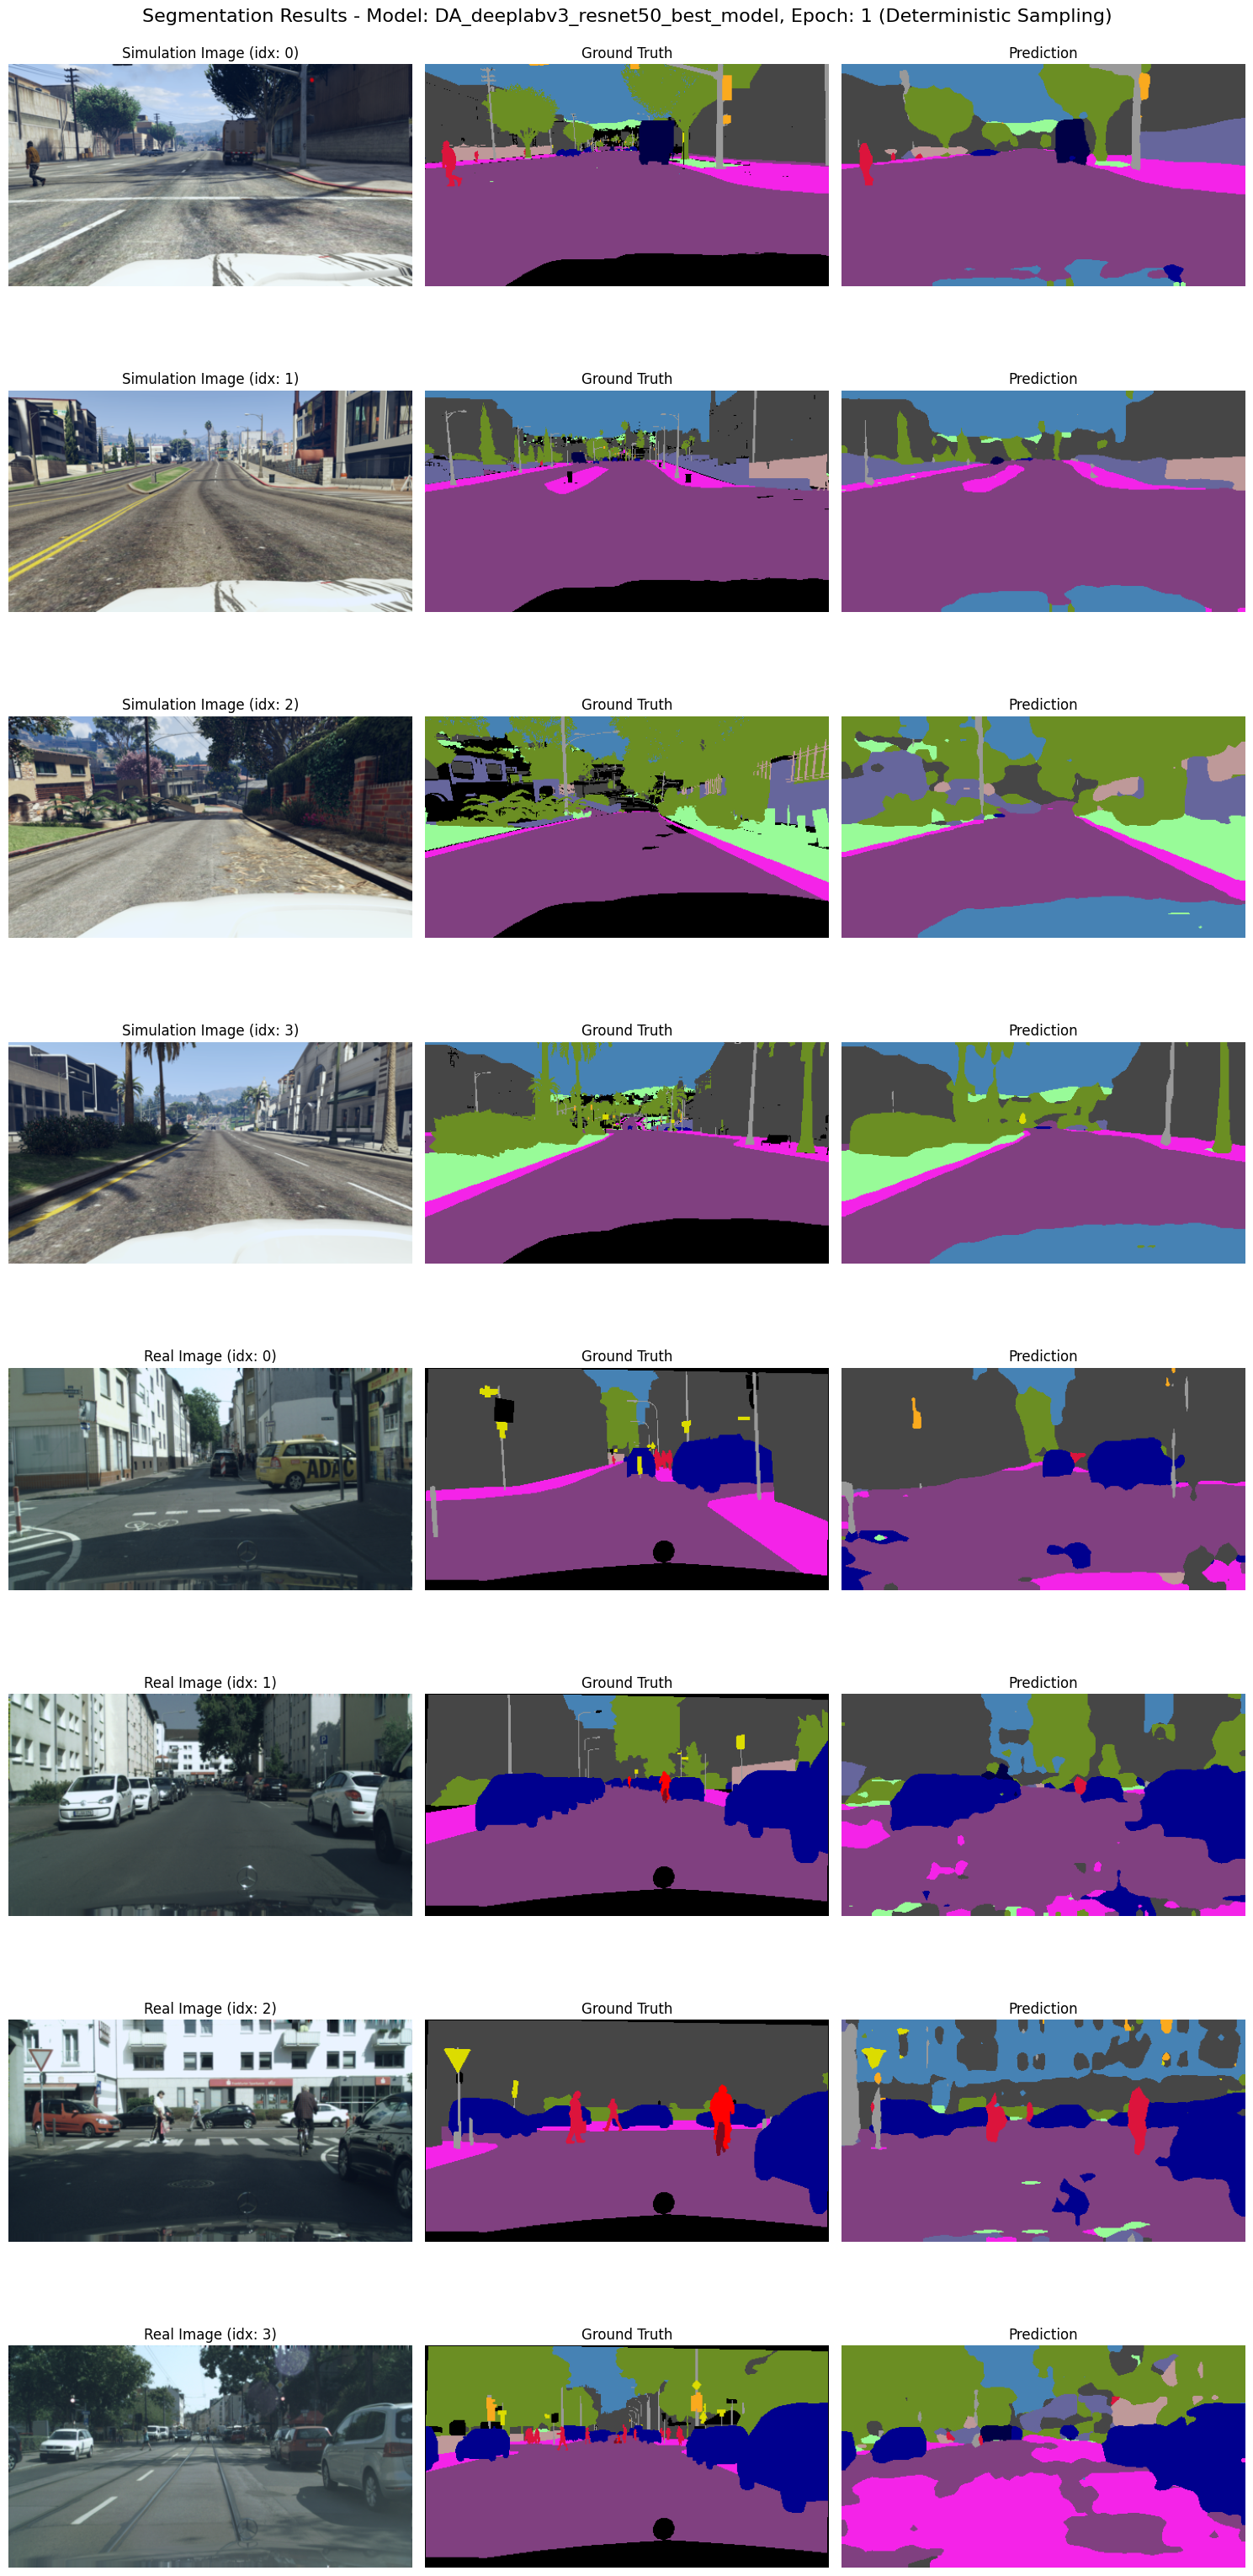

Model file not found: models/DA_deeplabv3_resnet50_best_model_best_unsupervised_model.pth


In [34]:
name = "DA_higherMMD_deeplabv3_imagenet1k"
name = "DA_deeplabv3_resnet50_best_model"

visualize_segmentation(
    name=name, 
    epoch="best_supervised", 
    sim_dataloader=syn_val_dataloader, 
    real_dataloader=real_val_dataloader, 
    num_samples=4,
    deterministic=True,
)
visualize_segmentation(
    name=name, 
    epoch="best_unsupervised", 
    sim_dataloader=syn_val_dataloader, 
    real_dataloader=real_val_dataloader, 
    num_samples=4,
    deterministic=True,
)

In [11]:
#name = "DA_lowerMMD_deeplabv3_imagenet1k"
name = "DA_deeplabv3_resnet50_best_model"

visualize_segmentation(
    name=name, 
    epoch="best_supervised", 
    sim_dataloader=syn_val_dataloader, 
    real_dataloader=real_val_dataloader, 
    num_samples=4,
    deterministic=True,
)
visualize_segmentation(
    name=name, 
    epoch="best_unsupervised", 
    sim_dataloader=syn_val_dataloader, 
    real_dataloader=real_val_dataloader, 
    num_samples=4,
    deterministic=True,
)

Model file not found: models/DA_deeplabv3_resnet50_best_model_best_supervised_model.pth
Model file not found: models/DA_deeplabv3_resnet50_best_model_best_unsupervised_model.pth
